### This notebook will be used to explore different time-series in order to find interesting insights

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

% matplotlib inline

In [3]:
conn = sqlite3.connect('db1.sqlite')
c = conn.cursor()

c.execute("SELECT date, close FROM Closing_Prices\
           WHERE symbol = 'CL'\
               AND date BETWEEN '2005-05-12' AND '2005-05-21';")
ts = c.fetchall()
conn.close()

In [4]:
def generate_time_series(product, start_year, end_year, db_file):
    ''' This function takes in a product, start_year, end_year, and database
        file then returns a dataframe of the time-series of closing prices given the parameters.

        Args: product - str product in database we want to create a time-series of closing prices
              start_year - int year to begin time-series
              end_year - int year to end the time-series
              db_file - str database filename

        Return: ts - the closing price time-series of product from start_year to end_year
    '''
    # Connect to database and create query
    conn = sqlite3.connect(db_file)
    query = "SELECT date, close FROM Closing_Prices\
             WHERE symbol = '{p}'\
                 AND date BETWEEN '{sy}-01-01' AND '{ey}-12-31';"\
            .format(p=product, sy=str(start_year), ey=str(end_year))
        
    # Read time-series data into dataframe
    ts = pd.read_sql(query, conn, index_col='date', parse_dates=['date'])
    
    return ts

In [5]:
cl_ts = generate_time_series('CL', 2006, 2007, 'db1.sqlite')

In [6]:
cl_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2006-01-03 to 2007-12-31
Data columns (total 1 columns):
close    501 non-null float64
dtypes: float64(1)
memory usage: 7.8 KB


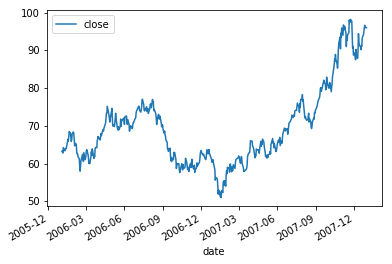

In [7]:
cl_ts.plot()

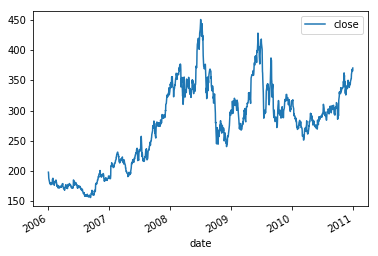

In [8]:
sm_ts = generate_time_series('SM', 2006, 2010, 'db1.sqlite')
sm_ts.plot()

In [9]:
import math
test = math.sqrt(252) * sm_ts.pct_change().rolling(window=25, center=False).std()

In [10]:
test.tail()

,close
date,
2010-12-27,0.215518
2010-12-28,0.189346
2010-12-29,0.182784
2010-12-30,0.173764
2010-12-31,0.176275


In [11]:
sm_ts.head()

,close
date,
2006-01-03,198.2
2006-01-04,195.1
2006-01-05,188.8
2006-01-06,186.9
2006-01-09,183.3


In [12]:
sm_ts['historical_vol'] = math.sqrt(252) * sm_ts.pct_change().rolling(window=20, center=False).std()

In [13]:
sm_ts.tail()

,close,historical_vol
date,,
2010-12-27,366.4,0.182553
2010-12-28,368.6,0.181346
2010-12-29,365.7,0.186442
2010-12-30,365.4,0.171794
2010-12-31,370.3,0.171607


In [25]:
def add_hist_vol(ts, period=20):
    ''' This function takes in a time-series and a period (default to 20) and returns a new
        time-series with a historical volatility column, based on the period given.
        
        Args: ts - dataframe time-series of closing price data
              period - int number of days used to calculate the historical vol
        
        Return: cpy - dataframe new time-series with added hist vol column
    '''
    # Create a copy of the time-series to manipulate, and a string name for new column
    cpy = ts.copy()
    col_name = '{}d_hist_vol'.format(str(period))
    
    # Add historical vol column given period length
    cpy[col_name] = round(math.sqrt(252) * cpy.pct_change().rolling(window=period, center=False).std(), 4)
    
    return cpy

In [15]:
cl_ts.head()

,close
date,
2006-01-03,63.14
2006-01-04,63.42
2006-01-05,62.79
2006-01-06,64.21
2006-01-09,63.50


In [16]:
cl_updated = add_hist_vol(cl_ts)

In [20]:
w_ts = generate_time_series('W', 2000, 2016, 'db1.sqlite')
w_ts.tail()

,close
date,
2016-12-08,390.75
2016-12-09,400.25
2016-12-12,401.25
2016-12-13,398.00
2016-12-14,391.50


In [22]:
add_hist_vol(w_ts)
w_ts.tail()

,close,20d_hist_vol
date,,
2016-12-08,390.75,0.25
2016-12-09,400.25,0.27
2016-12-12,401.25,0.27
2016-12-13,398.00,0.25
2016-12-14,391.50,0.26


In [24]:
c_ts = generate_time_series('C', 2000, 2016, 'db1.sqlite')
add_hist_vol(c_ts)
c_ts.tail()

,close,20d_hist_vol
date,,
2016-12-08,346.50,0.2281
2016-12-09,352.50,0.2342
2016-12-12,354.50,0.2310
2016-12-13,356.25,0.2275
2016-12-14,351.75,0.2308


In [26]:
s_ts = generate_time_series('S', 2000, 2016, 'db1.sqlite')
s_updated = add_hist_vol(s_ts)
s_ts.tail()

,close
date,
2016-11-08,1001.75
2016-11-09,982.00
2016-11-10,989.00
2016-11-11,978.50
2016-11-14,971.00


In [27]:
s_updated.tail()

,close,20d_hist_vol
date,,
2016-11-08,1001.75,0.1579
2016-11-09,982.00,0.1720
2016-11-10,989.00,0.1695
2016-11-11,978.50,0.1740
2016-11-14,971.00,0.1664


In [28]:
s_100 = add_hist_vol(s_ts, period=100)
s_100.tail()

,close,100d_hist_vol
date,,
2016-11-08,1001.75,0.2435
2016-11-09,982.00,0.2445
2016-11-10,989.00,0.2446
2016-11-11,978.50,0.2449
2016-11-14,971.00,0.2446


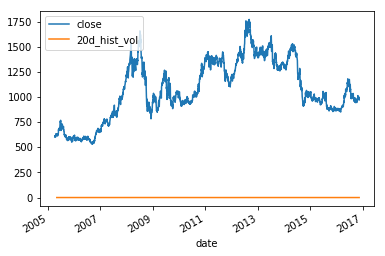

In [29]:
s_updated.plot()

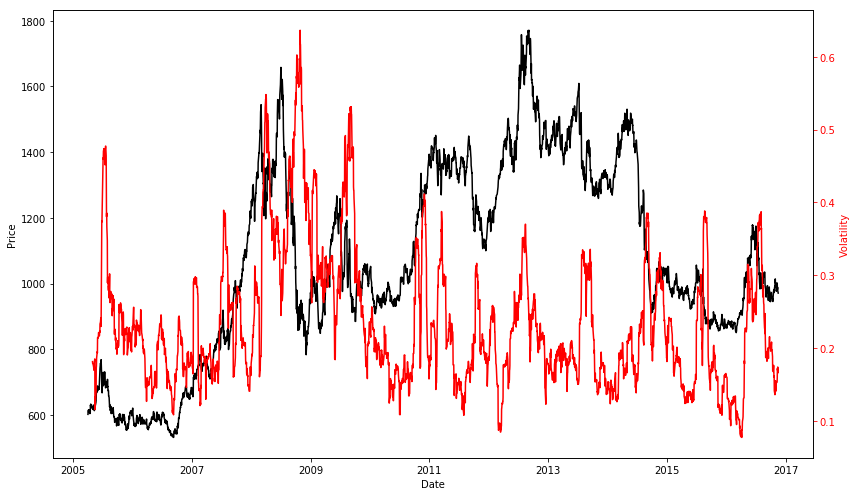

In [42]:
fig, ax1 = plt.subplots(figsize=(12,7))

ax1.plot(s_updated.index, s_updated['close'], label='Closing Price', color='k')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')

ax2 = ax1.twinx()
ax2.plot(s_updated.index, s_updated['20d_hist_vol'], label='20-day Historical Vol', color='r')
ax2.set_ylabel('Volatility', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

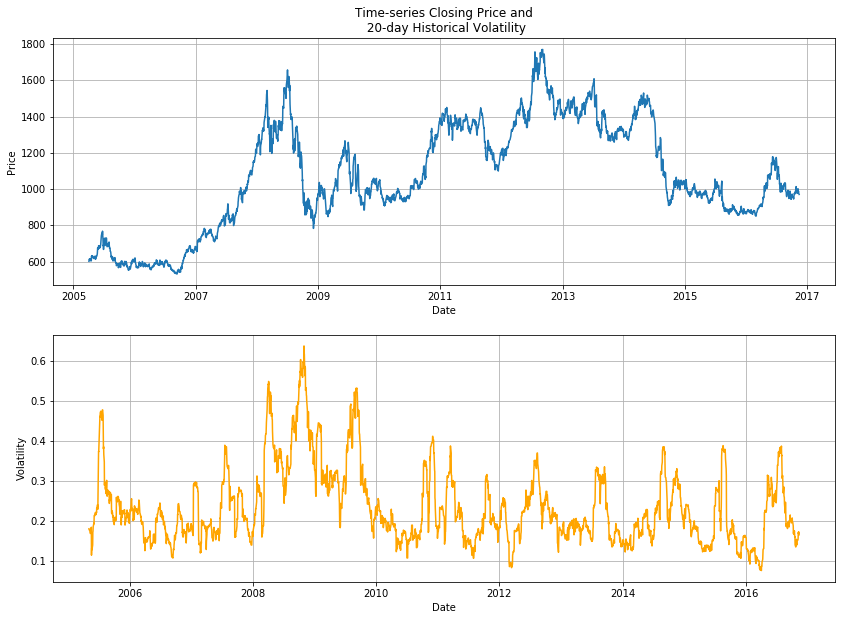

In [48]:
plt.figure(figsize=(14,10))

plt.subplot(2,1,1)

plt.plot(s_updated.index, s_updated['close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Time-series Closing Price and\n 20-day Historical Volatility')
plt.grid()

plt.subplot(2,1,2)

plt.plot(s_updated.index, s_updated['20d_hist_vol'], color='orange')
plt.xlabel('Date')
plt.ylabel('Volatility')

plt.grid()
plt.show()

In [73]:
def plot_ts(ts):
    ''' This function takes in a time-series and plots the closing price and historical vol data.
    
        Args: ts - dataframe of time-series of closing price and historical vol data
        
        Return: None - plots both the closing price and historical vol data for time-series
    '''
    # Extract period from time-series column name
    period = ts.columns.tolist()[1][:ts.columns.tolist()[1].find('d')]
    
    # Create figure and axes to plot each series of data
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), gridspec_kw={'height_ratios': [3, 1]})
    
    # Plot the closing prices
    ax1.plot(ts.index, ts['close'])
    ax1.set(title='Time-series Closing Price and\n {}-day Historical Volatility'.format(period))
    ax1.set_ylabel('Closing Price')
    ax1.grid()
    
    # Plot the historical volatility
    ax2.plot(ts.index, ts['{}d_hist_vol'.format(period)], color='orange')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volatility')
    ax2.grid()
    
    # Show both plots
    fig.tight_layout()
    fig.show()

/Users/Frank/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


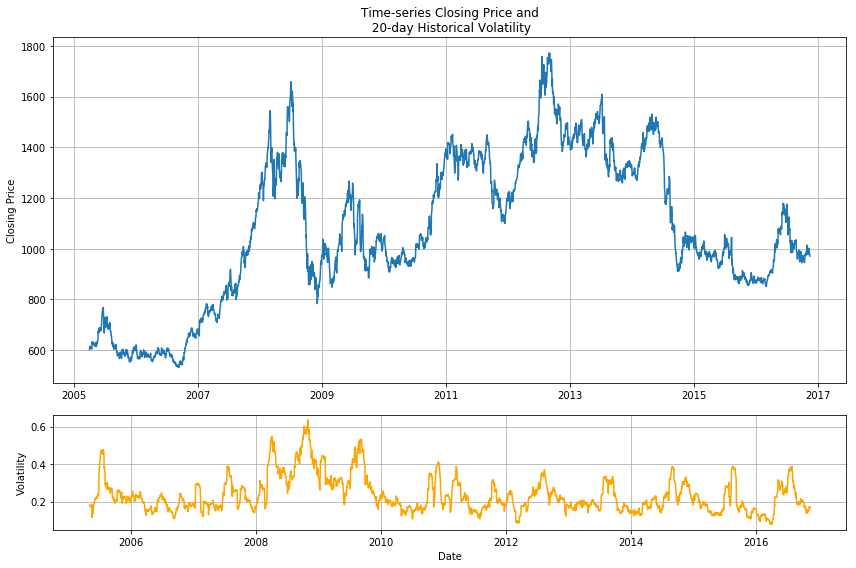

In [74]:
plot_ts(s_updated)

'20'